# SLT-CE-5: Pairwise Clustering

<p style="background-color:#adebad;"> 
legi 16-952-137
</p>

In this coding exercise you will apply pairwise clustering for proximity data and you will see how to use the mean-field approximation (MFA) approach with the EM-algorithm to get a labeling for a data object encoded by similarity and dissimilarity matrices. You will also be able to implement modifications of the EM-scheme to obtain embeddings into an Euclidean space.

<b> References: </b>

[1] T. Hoffman, JM Buhmann. Pairwise Data Clustering by Deterministic Annealing, 1996: http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.8.9812&rep=rep1&type=pdf 

Optionally, the following resources could be helpful:

[2] Lecture 7. Pairwise clustering: https://ml2.inf.ethz.ch/courses/slt/lectures/slt20_lecture07.pdf

[3] Lecture script. Chapter 3.2: https://ml2.inf.ethz.ch/courses/slt/tutorials/SLT_Script.pdf

[4] Lecture 4. Determenistic Annealing: https://ml2.inf.ethz.ch/courses/slt/lectures/slt20_lecture04.pdf

[5] Lecture 8. Mean-field approximation: https://ml2.inf.ethz.ch/courses/slt/lectures/slt20_lecture08.pdf

<h2 style="background-color:#f0b375;"> Setup </h2>

In [2]:
import sklearn as skl
import matplotlib.pyplot as plt
import matplotlib.cm
import numpy as np
import scipy as sp
import pandas as pd
import sys
from scipy.stats import mode
import warnings
warnings.filterwarnings('ignore')

from sklearn.utils.validation import check_is_fitted
from sklearn.cluster import SpectralClustering
from scipy.io import loadmat

#Please use this seed in all sections, except section 5.5
np.random.seed(111)

<h2 style="background-color:#f0b375;"> Data </h2>

## ProDom Data

ProDom is a comprehensive set of protein domain families [6]. A ProDom subset of 2604 protein domain sequences from the ProDom set was selected by [7]. These are chosen based on a high similarity to at least one sequence contained in the first four folds of the SCOP database. The pairwise structural alignments are computed [7]. Each SCOP sequence belongs to a group, as labeled by the experts [8]. The same four classes are assigned here.

<b> References: </b>

[6] F. Corpet, F. Servant, J. Gouzy and D. Kahn, ProDom and ProDom-CG: tools for protein domain analysis and whole genome comparisons, Nucleid Acids Res., vol. 28, 267-269, 2000.

[7] V. Roth, J. Laub, J.M. Buhmann, and K.-R. Mueller, Going metric: Denoising pairwise data, Advances in Neural Information Processing Systems, 841-856, MIT Press, 2003.

[8] A.G. Murzin, S.E. Brenner, T. Hubbard and C. Chothia, SCOP: a structural classification of proteins database for the investigation of sequences and structures, Journal of Molecular Biology, vol. 247, 536-540, 1995.


Download link: http://prtools.org/disdatasets/index.html#ProDom

In [3]:
prodom = {"input": loadmat("prodom.mat")}
# After some reverse-engineering:
prodom["similarity"] = np.array(prodom["input"]["s"])[0,0][0]
prodom["labels"] =np.array(prodom["input"]["s"])[0,0][2].flatten()

## Protein Data

The protein data are provided as a 213x213 dissimilarity matrix comparing the protein sequences based on the concept of an evolutionary distance. It was used for classification in [9] and for clustering in [10]. There are four classes of globins: heterogeneous globin (G), hemoglobin-A (HA), hemoglobin-B (HB) and myoglobin (M). Each protein in the dataset is classified into one of these four classes.

<b> References: </b>

[9] T. Graepel, R. Herbrich, P. Bollmann-Sdorra, K. Obermayer, Classification on pairwise proximity data. In Advances in Neural Information System Processing vol. 11, 438-444, 1999.

[10] T. Denoeux, T. and M.-H. Masson, EVCLUS: Evidential clustering of proximity data. IEEE Transations on Systems, Man and Cybernetics, vol. 34, 95-109, 2004.

Download link (use The PRTools version of Protein): http://prtools.org/disdatasets/index.html#Protein

In [4]:
protein = {"input": loadmat("protein.mat")}
protein["dissimilarity"] = np.array(protein["input"]["d"])[0,0][0]
protein["labels"] =np.array(protein["input"]["d"])[0,0][2].flatten()

<h2 style="background-color:#f0b375;">
Section 4.0 
<span style=font-size:50%> Complete all problems (4.0.1-4.0.9) in this section to get a pass on this exercise. </span>
</h2>

In this section, you have to give a description of the pairwise clustering approach based on deterministic annealing and mean-field approximation. Then you have to implement it, as described in Algorithm II in reference [1].


<p style="background-color:#adebad;"> 
<b>NOTE</b>: Please follow these guidelines: <br>
</p>
<ul style="background-color:#adebad;"> 
<li> Use consistent notation throughout the notebook. </li>
<li> Define every variable properly. </li>
<li> Define every math notation before usage. </li>
<li> Use math mode with $$ for formulas. </li>
</ul>


<p style="background-color:#adebad;">
    1. Implement the function <b>plot_pairwise()</b> according to its docstring. Hint: <b>usematplotlib.pyplot.matshow()</b> to visualize matricies, <b>matplotlib.pyplot.axhspan(),matplotlib.pyplot.axvspan()</b> to add horizontal and vertical rectangles to the plot.
</p>

In [5]:
def permute_matrix(M, p):
    N = M.copy()
    N[:,:] = M[p,:]
    N[:,:] = M[:,p]
    return N

In [6]:
def plot_pairwise(data, labels, cmap="binary", alpha=0.33):
    """Plot (dis-)similarity data
    
    Args:
        data (np.ndarray): Symmetric (dis-)similarity array (n_samples, n_samples)
        labels (np.array): Cluster label array  (n_samples,)
        cmap (str): Color Map for (dis-)similarity values. Please use matplotlib colormaps. See here for details: 
        https://matplotlib.org/tutorials/colors/colormaps.html
        alpha (float): Opacity of cluster overlay, between 0 and 1
        
    Shows:
        Image plot of (dis-)similarity matrix, overlaid with transparent blocks,
        which indicate the clusters contained in labels.
        Note: Permute the data according to the sorting of the labels.
        
    Prints:
        Minimum, Maximum and Median of (dis-)similarity values
        Warning, if (dis-)similarity matrix is not symmetric
        
    Returns:
        This is void function. No return required.
    """
    # Check that data is symmetric
    if not np.any(np.isclose(data-data.transpose(), np.zeros_like(data))):
        print("Data isn't symmetric")
    print("Max {} Min {} Median {}".format(np.max(data), np.min(data), np.median(data)))
    # Permute data according to labels
    perm = np.argsort(labels)
    data_perm = permute_matrix(data, perm)
    
    figure = plt.figure() 
    axes = figure.add_subplot(111) 

    # using the matshow() function  
    caxes = axes.matshow(data, cmap=cmap) 
    figure.colorbar(caxes)
    cmap = matplotlib.cm.get_cmap('hsv')
    N = np.shape(data)[0]
    y = [0]
    labels_sorted = sorted(labels)
    for i in range(N-1):
        if labels_sorted[i+1] != labels_sorted[i]:
            y.append(i+1)
    y.append(N-1)
    for ind, y1 in enumerate(y[:-1]):
        y2 = y[ind+1]
        plt.axhspan(y1, y2-1, xmin=y1/N, xmax=(y2-1)/N, alpha=alpha, color=cmap(ind/len(y)))
    plt.show() 


Max 478835 Min -15529 Median -8847.0


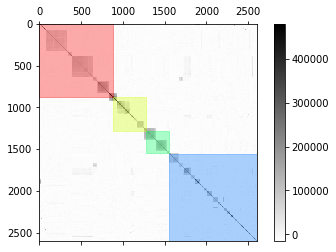

In [7]:
plot_pairwise(prodom["similarity"], prodom["labels"])
# color line-legend on right for better undersanding of the map

Max 478835 Min -15529 Median -8847.0


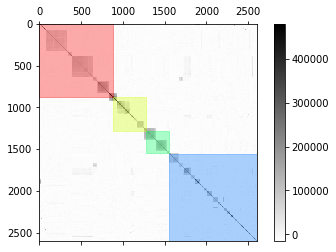

In [8]:
#Example how output should looks like after the following command
plot_pairwise(prodom["similarity"], prodom["labels"])

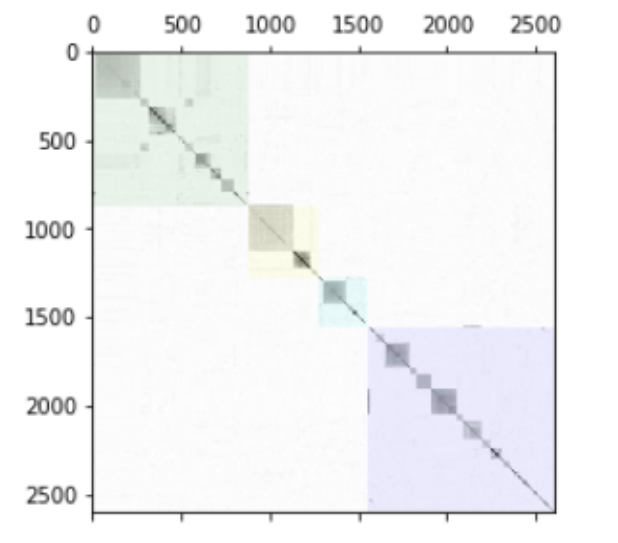

<p style="background-color:#adebad;">
    2. Demonstrate your implementation of <b> plot_pairwise() </b> below.
</p>

Max 13.64 Min 0.0 Median 11.23


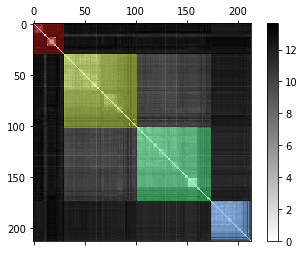

In [9]:
plot_pairwise(protein["dissimilarity"], protein["labels"])

**Notation**
Let us have $N$ points $\mathbf{x}_i\in \mathbb{R}^d, i=1,\ldots,N$ and $K$ clusters $C_\nu$ with their centroids $\mathbf{y}_\nu\in \mathbb{R}^d, \nu=1,\ldots,K$.

Let $M_{i\nu}$ be the assignment map of our assumptions: $M_{i\nu}=\mathbb{I}\{\mathbf{x}_i \in C_\nu\}\in \{0,1\}$ - indicator function (at any point $\sum_{\nu=1}^K M_{i\nu} = 1 \forall i$).

$\mathcal{D}: (\mathbb{R}^d, \mathbb{R}^d) \rightarrow \mathbb{R}$ is a dissimilarity function. 

$T > 0$ is the computational temperature.

Denote $\langle M_{i\nu}\rangle = \frac{exp(-\mathcal{D}(\mathbf{x}_i, \mathbf{y}_\nu)/T}{\sum_{\nu = 1}^K exp(-\mathcal{D}(\mathbf{x}_i, \mathbf{y}_\nu)/T}$ (1)

Upper index as a non-negative integer in parenthesis denotes step of algorithm corresponding to this integer.

Denote centroid equation as $0=\sum_{i=1}^N \langle M_{i\nu}\rangle \frac{\partial}{\partial \mathbf{y}_\nu} \mathcal{D}(\mathbf{x}_i, \mathbf{y}_\nu)$ (2)

<p style="background-color:#adebad;">
Read reference [1] and answer the following questions:
</p>
<p style="background-color:#adebad;">
3. Provide a description of the general EM algorithm with main formulas. <br>
</p>

**EM-algorithm**

Given are $N$ points $\mathbf{x}_i\in \mathbb{R}^d, i=1,\ldots,N$, \mathcal{D}, initial temperature $T_0>0$ and needed $K$.

0) Initialize $\mathbf{y}_\nu^{(0)}\in \mathbb{R}^d$,  $\langle M_{i\nu}\rangle^{(0)}\in \{0,1\}$ randomly, current temperature $T\leftarrow T_0$, minimal temperature $T_{\text{final}}$.

WHILE $T>T_{\text{final}}$ DO:

$\hspace{1cm}$
$t\leftarrow0$

$\hspace{1cm}$
REPEAT
    
$\hspace{2cm}$
E-step: estimate all $\langle M_{i\nu}\rangle^{(t+1)}$ from (1)

$\hspace{2cm}$
M-step: calculate all $\mathbf{y}_\nu^{(t+1)}$ solving corresponding (2)

$\hspace{2cm}$
$t\leftarrow t+1$
    
$\hspace{1cm}$
UNTIL for all $i, \nu$ (1) and (2) are satisfied with high accuracy with current $\langle M_{i\nu}\rangle^{(t+1)}$ and $\mathbf{y}_\nu^{(t+1)}$.

$\hspace{1cm}$
Change $T$ according to schedule (e.g. $T\leftarrow T/2$)

$\hspace{1cm}$
$\langle M_{i\nu}\rangle^{(0)} \leftarrow \langle M_{i\nu}\rangle^{(t)},
\mathbf{y}_\nu^{(0)} \leftarrow \mathbf{y}_\nu^{(t)}$

<p style="background-color:#adebad;">
4. Why is it not possible to apply the EM-scheme for central clustering (algorithm I in [1]) to the case of pairwise clustering? <br>
</p>

Our data isn't set of points in Euclidean space, we have initially only dissimilarities between them, they could even not be a proper distances

Also, $M_{i\nu}$ are not independent as in case of central clustering, which doesn't allow to directly factorize Gibbs distribution

<p style="background-color:#adebad;">
5. Describe the idea of mean-field approximation (as KL divergency minimization problem) with the main formulas. How does mean field approximaiton help to solve the problem from the previous question?<br>
</p>

The idea is to approximate the average interaction of $M_{i\nu}$ with other assignment variables by mean-field average $\mathcal{E}_{i\nu}^*$ in the limit of high size of data. It is found as a closest to the Gibbs $\mathbf{P}(\mathcal{H}^{PC})$ distribution in terms of KL-divergence within a family of distributions $\mathbf{P}^0$ parametrized by $\mathcal{E}$:
$$\mathcal{E^*} = \arg\min_\mathcal{E} D_{KL} (\mathbf{P}^0(\mathcal{E})||\mathbf{P}(\mathcal{H}^{pc})$$

Solving this, we get
$$\langle M_{i\alpha}\rangle = \frac{exp(-\mathcal{E}_{i\alpha}^*/T)}{\sum_{\nu = 1}^K exp(-\mathcal{E}_{i\nu}^*/T)}. (3)$$

Using reasonable in case $N\rightarrow\infty$ approximations and assuming diagonal elements of dissimilarity matrix to be zero, we have
$$\mathcal{E}_{i \nu}^{*}=\frac{1}{\left\langle p_{\nu}\right\rangle N} \sum_{k=1}^{N}\left\langle M_{k \nu}\right\rangle\left(\mathcal{D}_{i k}-\frac{1}{2\left\langle p_{\nu}\right\rangle N} \sum_{j=1}^{N}\left\langle M_{j \nu}\right\rangle \mathcal{D}_{j k}\right),  (4)$$ where $p_\nu = \sum_{i=1}^N M_{i\nu}/N \Rightarrow \langle p_\nu\rangle = \sum_{i=1}^N \langle M_{i\nu}\rangle/N$.

<p style="background-color:#adebad;">
6. Provide a description of the EM algorithm for pairwise clustering for the case if we have proximity data (algorithm II in [1]). <br>
</p>

**EM-algorithm**

Given are matrix of pairwise dissimilarities of $N$ points $\mathcal{D}$ of size $N\times N$, initial temperature $T_0>0$ and needed $K$.

0) Initialize ${\mathcal{E}_{i\nu}^{*}}^{(0)}$,  $\langle M_{i\nu}\rangle^{(0)}\in \{0,1\}$ randomly, current temperature $T\leftarrow T_0$, minimal temperature $T_{\text{final}}$.

WHILE $T>T_{\text{final}}$ DO:

$\hspace{1cm}$
$t\leftarrow0$

$\hspace{1cm}$
REPEAT
    
$\hspace{2cm}$
E-step: estimate all $\langle M_{i\nu}\rangle^{(t+1)}$ from (3) using ${\mathcal{E}_{i\nu}^*}^{(t)}$

$\hspace{2cm}$
M-step: calculate all ${\mathcal{E}_{i\nu}^*}^{(t+1)}$ from corresponding (4) using $\langle M_{i\nu}\rangle^{(t+1)}$

$\hspace{2cm}$
$t\leftarrow t+1$
    
$\hspace{1cm}$
UNTIL for all $i, \nu$ (3) and (4) are satisfied with high accuracy with current $\langle M_{i\nu}\rangle^{(t+1)}$ and ${\mathcal{E}_{i\nu}^*}^{(t+1)}$.

$\hspace{1cm}$
Change $T$ according to schedule (e.g. $T\leftarrow T/2$)

$\hspace{1cm}$
$\langle M_{i\nu}\rangle^{(0)} \leftarrow \langle M_{i\nu}\rangle^{(t)},
{\mathcal{E}_{i\nu}^{*}}^{(0)} \leftarrow {\mathcal{E}_{i\nu}^{*}}^{(t)}$

<p style="background-color:#adebad;">   
7. Implement the <b>fit_predict()</b> method without embedding (Algorithm II in [1]) for the template <b>class PairwiseClustering</b>, according to its docstring. You can add more class methods if necessary <br>
</p>

Formulas for algorithm III:

$$\mathbf{K}_{i} \mathbf{x}_{i} \approx \frac{1}{2} \sum_{\nu=1}^{K}\left\langle M_{i \nu}\right\rangle\left(\left\|\mathbf{y}_{\nu}\right\|^{2}-\mathcal{E}_{i \nu}^{*}\right)\left(\mathbf{y}_{\nu}-\sum_{\mu=1}^{K}\left\langle M_{i \mu}\right\rangle \mathbf{y}_{\mu}\right), \;\;\; (5)$$
where
$$\mathbf{K}_i = \langle \mathbf{y} \mathbf{y}^\top\rangle_i - \langle\mathbf{y} \rangle_i\langle\mathbf{y}\rangle_i^\top$$
and $$\langle\mathbf{y} \rangle_i = \sum_{\nu=1}^K \langle M_{i\nu}\rangle \mathbf{y}_\nu$$

Centroid condition
$$\mathbf{y}_{\nu}=\sum_{k=1}^{N} M_{k \nu} \mathbf{x}_{k} / \sum_{k=1}^{N} M_{k \nu}\;\;(6)$$ 

$$\langle M_{i\nu}\rangle = \frac{\exp(-||\mathbf{x}_i - \mathbf{y}_\nu||^2/T)}{\sum_{\nu = 1}^K \exp(-||\mathbf{x}_i - \mathbf{y}_\nu||^2/T)}\;\;\; (7)$$ 

In [76]:
class PairwiseClustering(skl.base.BaseEstimator, skl.base.TransformerMixin):
    """Template class for PairwiseClustering (PC)
    
    Attributes:
        M (np.ndarray): Assignment probability matrix (n_samples, n_clusters)
        centroids (np.ndarray): Embedding centroids (n_clusters, n_components), 
                                used only if embed is True.
        embeddings (np.ndarray): Embeddings of input samples (n_samples, n_components),
                                 used only if embed is True.
    Parameters:
        n_clusters (int): Maximum number of clusters.
        random_state (int): Random seed.
        embed (bool): Indicator, if data should be clustered and embedded simultaneously (algorithm III),
                      or not (algorithm II).
        n_components (int): Dimension of embedding space, used only if embed is True
    """
    
    def __init__(self, n_clusters=4, random_state=1, embed=False, n_components=2, 
                 T=1, T_f=0.0001, eps=1e-4, rate=0.5, eps_embed=0.05):
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.embed = embed
        self.n_components = n_components
        self.T = T
        self.T_f = T_f
        self.eps = eps
        self.rate = rate
        self.M = None
        self.eps_embed = eps_embed
        # Add more parameters, if necessary.
        self.Eps_star = None
        self.X_embed = None
        self.M_av = None
        self.labels = None
    def fit_predict(self, X, embed=False):
        """Compute PC for dissimilarity matrix X
        
        Compute cluster assignments. If embed is True, also compute embeddings/centroids.
         
        Args:
            X (np.ndarray): Dissimilarity matrix (n_samples, n_samples)
        
        Returns:
            C (np.ndarray): Assignments (n_samples,). 
            This is MAP estimation obtained from matrix M in accordance with notation 
            from reference [1]. 
        """
        np.random.seed(self.random_state)
        
        
        if embed == False:
            # Algorithm II from [1] should be implemented here 
            # (this is part of the Section 4.0)
            N = np.shape(X)[0]
            K = self.n_clusters
            Eps_star = np.random.rand(N, K)  # N x K
            M_av = np.random.rand(N, K)
            M_av_prev = M_av.copy()
            T_curr = self.T
            while T_curr > self.T_f:
                t = 0
                while True:
                    # estimate M (25) in [1]
                    M_av = np.exp(-Eps_star/T_curr 
                                   - np.matlib.repmat(
                                       sp.special.logsumexp(-Eps_star/T_curr, axis=1), # 1xN
                                       K, 1).transpose()) # N x K
                    # calculate Eps_star (26) in [1]
                    p_av_N = 1 / np.sum(M_av, axis=0)  # length K
                    p_av_N_extended = np.matlib.repmat(p_av_N, N, 1)  # N x K
                    a = X.transpose() @ M_av
                    b = M_av * 0.5*p_av_N_extended * a
                    Eps_star = p_av_N_extended * (X @ M_av - 
                                    M_av * 0.5*p_av_N_extended * (X.transpose() @ M_av))
                    if not np.any(np.abs(M_av_prev - M_av) > self.eps):
                        # check that (25) is still close to the truth ((26) is true)
                        #print("Achieved t: {}".format(t))
                        break
                    M_av_prev = M_av.copy()
                    t += 1
                T_curr *= self.rate
            #print(M_av)
            labels = np.argmax(M_av, axis=1)
            M = np.zeros(np.shape(M_av))
            for i in range(np.shape(labels)[0]):
                M[i, labels[i]] = 1
            self.M_av = M_av
            self.M = M
            self.Eps_star = Eps_star
            self.labels = labels
            return labels
                
        if embed == True:
            #Algorithm III from [1] should be implemented here (this is part of the Section 6.0)
            N = np.shape(X)[0]
            K = self.n_clusters
            d = self.n_components
            y = np.random.rand(K, d)
            x_emb = np.random.rand(N, d)
            x_emb_prev = x_emb.copy()
            # Get Eps_star
            _ = self.fit_predict(X, embed=False)
            T_curr = self.T
            M_av_prev = self.M_av
            Eps_star = self.Eps_star
            while T_curr > self.T_f:
                t = 0
                while True:            
                    # E-step (7) from [here]
                    # Create matrix N x K of distances between x_i and y_\nu
                    dist = np.empty((N,K))
                    for i in range(N):
                        for j in range(K):
                            dist[i][j] =  np.linalg.norm(x_emb[i,:] - y[j,:])**2
                    # Estimate M from (7) from [here]
                    M_av = np.exp(-dist/T_curr - np.matlib.repmat(
                                    sp.special.logsumexp(-dist/T_curr, axis=1), # 1xN
                                    K, 1).transpose()) # N x K
                    # M-step
                     # Complex function and small dimensions, so we use loops further
                     # instead of more efficient matrix calculations if they are hard to implement
                    t_emb = 0
                    while True:    
                        # x_emb update (33) in [1], (5) [here]
                        # Get <y>_i<y>_i^T
                        y_av = (M_av @ y).transpose()  # d x N
                        y_cov = np.empty((d,d,N))
                        for i in range(N):
                            y_cov[:,:,i] = np.outer(y_av[:,i], y_av[:,i])  # d x d x N
                        # Get <yy^T>_i    
                        yy_av = np.empty((d,d,N))
                        for i in range(N):
                            yy_av[:,:,i] = np.dot(
                                np.multiply(
                                    np.matlib.repmat(M_av[i, :], d, 1), y.transpose()), 
                                y) # d x d
                        K_i = yy_av - y_cov  # d x d x N
                        # update x
                        for i in range(N):
                            x_emb[i,:] = 0.5 * np.linalg.inv(K_i[:,:,i]) \
                                @ (M_av[i,:] * (np.linalg.norm(y)**2 - Eps_star[i,:]) \
                                @ (y - y_av[:,i].transpose()))
                        # Debug
                        if t_emb % 500 == 0:
                            print("x_emb[0] {}, t_emb= {}".format(x_emb[0], t_emb))
            
                        # update y from centroid condition (6) [here]
                        y = M_av.transpose() @ x_emb \
                            / np.matlib.repmat(np.sum(M_av, axis=0), d, 1).transpose()
                        t_emb_max = 1e4
                        if not np.any(np.abs(x_emb_prev - x_emb) > self.eps_embed) \
                            or t_emb == t_emb_max:
                            if t_emb == t_emb_max:
                                print("Break after {} t_emb iterations".format(t_emb_max))
                            break
                        x_emb_prev = x_emb.copy()
                        t_emb += 1
                    # End of M-step WHILE
                    t_max = 10
                    if not np.any(np.abs(M_av_prev - M_av) > self.eps) or t == t_max:
                        print("Break after {} t iterations".format(t_max))
                        break
                    M_av_prev = M_av.copy()
                    t += 1
                T_curr *= self.rate    
            self.x_emb = x_emb
            return x_emb
            

    def cost(self, D, M, adjusted=True):
        """Compute the costs of the clustering solution M for dissimilarity D.
        
        The costs refer to the pairwise clustering costs in eq. (16) of reference [1].
        
        Args:
            D (np.ndarray): Dissimilarity matrix (n_samples, n_samples)
            M (np.ndarray): Assignment probability matrix (n_samples, n_clusters)
            
        Returns:
            cost (float): Costs of current clustering
        """
        
        #Please add your code here
        N, K = np.shape(M)
        p = 1 / (np.sum(M, axis=0) / N) # 1 x K
        p = np.matlib.repmat(p, N, 1) # N x K
       # print(p)
        M_kl = np.multiply(M, p) @ M.transpose()
        if adjusted:
            M_kl = M_kl - np.ones((N,N))
        cost = 0.5 / N * (np.sum(np.multiply(D, M_kl)))
                
        return cost

<p style="background-color:#adebad;">
8. Create an instance of your Pairwise Clustering (PC) class, then fit and predict the Protein data. <br>
9. Record the execution time.
</p>

In [48]:
%%time
PC = PairwiseClustering()
labels_pc = PC.fit_predict(protein["dissimilarity"])

CPU times: user 95.2 ms, sys: 0 ns, total: 95.2 ms
Wall time: 50.8 ms


<h2 style="background-color:#f0b375;">
Section 4.5 
<span style=font-size:50%> Complete all problems in this (4.5.1-4.5.5) and previous sections to get a grade of 4.5 </span>
</h2>

In this section, you have to compare pairwise clustering with another clustering approach, that also works with proximity data, in terms of different metrics.

<p style="background-color:#adebad;">
1. Read https://scikit-learn.org/stable/modules/clustering.html#spectral-clustering and shortly recap the idea of spectral clustering.
</p>

Uses clustering of eigenvectors components in the low-dimensional embedding of the affinity (transformed dissimilarity in our case) matrix 


<p style="background-color:#adebad;">
2. Predict the Protein data with sklearn.SpectralClustering. <br>
3. Record the execution time. <br>
</p>

In [51]:
%%time
SC = skl.cluster.SpectralClustering(n_clusters=4, random_state=42, affinity="precomputed")
affinities = np.exp(- protein["dissimilarity"] / 3) # SC takes positive affinities as input
labels_spectral= SC.fit_predict(affinities)

CPU times: user 102 ms, sys: 7.93 ms, total: 110 ms
Wall time: 79.2 ms


<p style="background-color:#adebad;">
4. Complete the function <b>compare_clusterings()</b> and use it to compare the spectral and the pairwise clustering methods. <br>
Use the following metrics to compare clusterings:
</p>
<ul style="background-color:#adebad;"> 
<li> V-measure cluster labeling given a ground truth. </li>
<li> Normalized Mutual Information between two clusterings. </li>
<li> Homogeneity metric of a cluster labeling given a ground truth. </li>
<li> The Fowlkes-Mallows score </li>
<li> Rand index adjusted for chance. </li>
<li> Adjusted Mutual Information between two clusterings. </li>
</ul>
<p style="background-color:#adebad;">
Hint: use <b>sklearn.metrics.v_measure_score(),sklearn.metrics.normalized_mutual_info_score(), sklearn.metrics.homogeneity_score(), sklearn.metrics.fowlkes_mallows_score(), sklearn.metrics.completeness_score(), sklearn.metrics.adjusted_rand_score(), sklearn.metrics.adjusted_mutual_info_score()</b>. You can also find explanations and examples there: https://scikit-learn.org/stable/modules/classes.html?highlight=metrics#module-sklearn.metrics
</p>

In [49]:
def compare_clusterings(labels_true, **labels_pred):
    """Show a summary of different clustering metrics
    
    Args:
        labels_true (array): Ground-truth cluster labels
    
    Note:
        Each kwarg should be an array with predicted labels
    """
    
    n_pred = len(labels_pred)
    
    score_names = ["v_measure_score", "normalized_mutual_info_score",
                   "homogeneity_score", "fowlkes_mallows_score",
                   "completeness_score", "adjusted_rand_score",
                   "adjusted_mutual_info_score"]
    
    scores = []
    for name in dir(skl.metrics.cluster):
        score = getattr(skl.metrics.cluster, name)
        try:
            score(labels_true=[0], labels_pred=[0]) # Check if score takes the right arguments
            if "score" not in score.__name__:
                raise TypeError
            for score_name in score_names:
                if score.__name__ == score_name:
                    scores.append(score)       
        except TypeError:
            continue
            
    
    
    df = pd.DataFrame(index=score_names, columns = labels_pred.keys(), dtype='float64')
    df = df.fillna(0)
    for key, val in labels_pred.items():     
        #Please add your code here
        for score in scores:
            df.at[score.__name__, key] = score(labels_true, val)
        print("{}_avg = {}".format(key, df[key].mean()))
    display(df)
    df.plot.barh().legend(loc='center left',bbox_to_anchor=(1.0, 0.9))
    return df 

<p style="background-color:#adebad;">
    5. Demonstrate your implementation of <b>compare_clusterings()</b>. See example of how the output should look like below. You should produce one plot. Hint: use <b>matplotlib.pyplot.barh(), matplotlib.pyplot.xticks(), matplotlib.pyplot.yticks()</b> to get horizontal histogram for different metrics as shown below.

</p>

SpectralClustering_avg = 0.7963915350418663
PairwiseClustering_avg = 0.8953569762059337
GroundTruth_avg = 1.0


,SpectralClustering,PairwiseClustering,GroundTruth
v_measure_score,0.803341,0.885313,1.0
normalized_mutual_info_score,0.805324,0.885375,1.0
homogeneity_score,0.750683,0.874997,1.0
fowlkes_mallows_score,0.842005,0.938875,1.0
completeness_score,0.863943,0.895875,1.0
adjusted_rand_score,0.763129,0.914174,1.0
adjusted_mutual_info_score,0.746316,0.872890,1.0


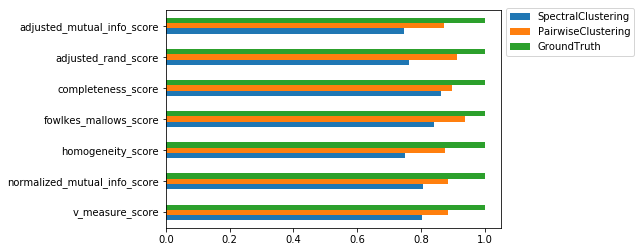

In [52]:
df = compare_clusterings(labels_true=protein["labels"],
                        SpectralClustering=labels_spectral,
                        GroundTruth=protein["labels"],
                        PairwiseClustering=labels_pc)

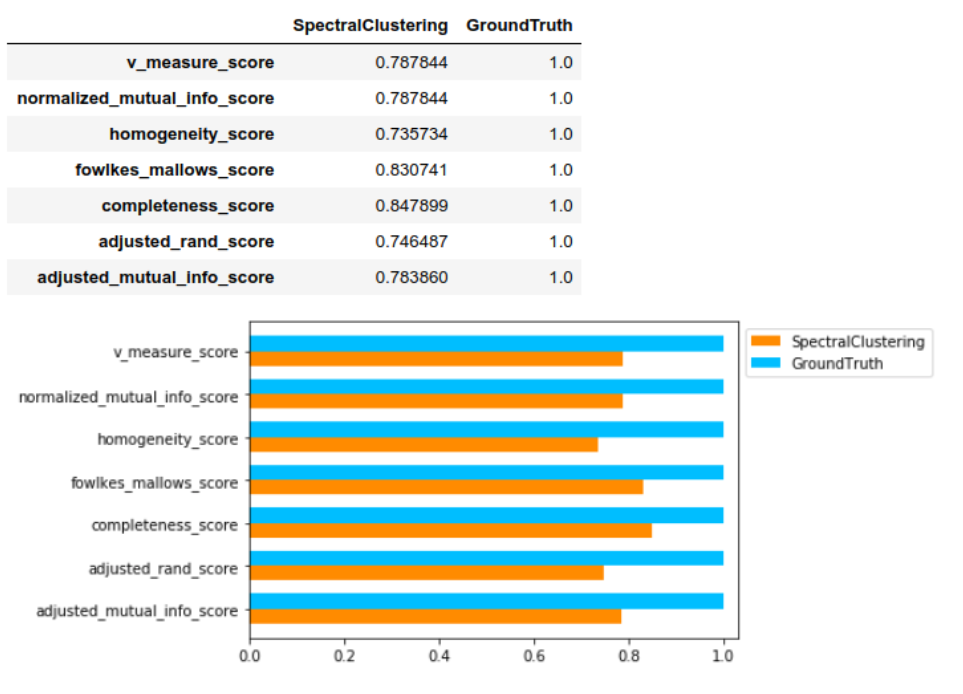

<h2 style="background-color:#f0b375;">
Section 5.0 
<span style=font-size:50%> Complete all problems in this (5.0.1-5.0.5) and previous sections to get a grade of 5.0 </span>
</h2>

In this section, you have to investigate the quality of clustering depending on various transformations from similarity data to dissimilarity data and compare results, in terms of different metrics.

<p style="background-color:#adebad;">
    As PairwiseClustering takes dissimilarities as input, we need to transform the similarity data from <b>Prodom</b> accordingly.<br>
    1. Run <b>fit_predict()</b> with all the transformations and parameters below. Run compare_clusterings for each set of parameter values for your <b>PairwiseClustering</b> algorithm. <br>
    2. Produce the output of <b>compare_clusterings()</b> for transformation families below. You should get 3 plots: 1st transformation family comparison, 2nd transformation family comparison, then comparison between of the best transformations of every family.<br>
<b>NOTE</b>: The best transformation in a family is the one that has the maximum average of all the scores above.
</p>

pw1_avg = 0.31339533400598935
GroundTruth_avg = 1.0
pw2_avg = 0.33787787772817085
exp_avg = 0.355600310748744


,pw1,GroundTruth,pw2,exp
v_measure_score,0.297921,1.0,0.325491,0.344688
normalized_mutual_info_score,0.298243,1.0,0.325692,0.344902
homogeneity_score,0.312453,1.0,0.337348,0.357273
fowlkes_mallows_score,0.463828,1.0,0.480509,0.492415
completeness_score,0.284680,1.0,0.314439,0.332959
adjusted_rand_score,0.252862,1.0,0.268110,0.284862
adjusted_mutual_info_score,0.283781,1.0,0.313557,0.332102


CPU times: user 12.6 s, sys: 148 ms, total: 12.8 s
Wall time: 6.67 s


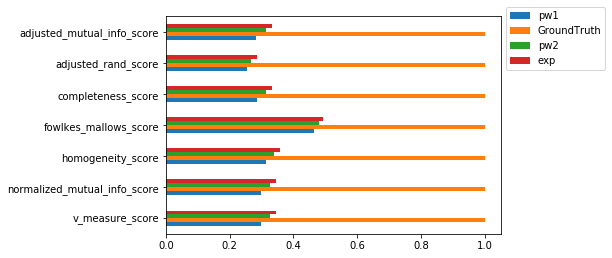

In [112]:
%%time
#Transformation family 1
# D = ((max(S) - S) / (max(S) - min(S))) ** 1
# D = ((max(S) - S) / (max(S) - min(S))) ** 2
# D = np.exp(((max(S) - S) / (max(S) - min(S))))

#Please add your code here
S = prodom["similarity"]
ma = np.max(prodom["similarity"])
mi = np.min(prodom["similarity"])
mam = np.matlib.repmat(ma, *np.shape(S))
n = 3
D = [None] * n
D[0] = (mam - S) / (ma - mi)
D[1] = D[0]**2
D[2] = np.exp(D[0])

PC = PairwiseClustering()
clusterings_1 = [None] * n
for i in range(n):
    clusterings_1[i] = PC.fit_predict(D[i])
    
_ = compare_clusterings(labels_true=prodom["labels"],
                        pw1=clusterings_1[0],
                        pw2=clusterings_1[1],
                        exp=clusterings_1[2],
                        GroundTruth=prodom["labels"])

The best here is exponential (though not much better)

pw1_avg = 0.35671847275879015
GroundTruth_avg = 1.0
pw1_2_avg = 0.3865256546068792
log_avg = 0.41830572016425743


,pw1,GroundTruth,pw1_2,log
v_measure_score,0.357309,1.0,0.379133,0.418308
normalized_mutual_info_score,0.357621,1.0,0.379557,0.418715
homogeneity_score,0.372900,1.0,0.397941,0.437612
fowlkes_mallows_score,0.468291,1.0,0.509488,0.521709
completeness_score,0.342968,1.0,0.362022,0.400635
adjusted_rand_score,0.255805,1.0,0.316318,0.331283
adjusted_mutual_info_score,0.342135,1.0,0.361222,0.399878


CPU times: user 59.7 s, sys: 504 ms, total: 1min
Wall time: 33.7 s


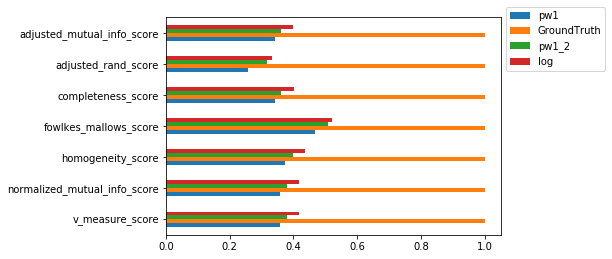

In [258]:
%%time
#Transformation family 2
# D = (max(S) / (1 + S - min(S))) ** 1
# D = (max(S) / (1 + S - min(S))) ** 1/2
# D = np.log((max(S) / (1 + S - min(S))))

#Please add your code here
mim = np.matlib.repmat(mi, *np.shape(S))
ones = np.ones(np.shape(S)[0])
D = [None] * n
D[0] = ma / (ones + S - mim)
D[1] = D[0]**(0.5)
D[2] = np.log(D[0])

PC = PairwiseClustering()
clusterings_2 = [None] * n

for i in range(n):
    clusterings_2[i] = PC.fit_predict(D[i])
    
_ = compare_clusterings(labels_true=prodom["labels"],
                        pw1=clusterings_2[0],
                        pw1_2=clusterings_2[1],
                        log=clusterings_2[2],
                        GroundTruth=prodom["labels"])

Here logarithmic is the best

best2_avg = 0.41830572016425743
GroundTruth_avg = 1.0
best1_avg = 0.355600310748744


,best2,GroundTruth,best1
v_measure_score,0.418308,1.0,0.344688
normalized_mutual_info_score,0.418715,1.0,0.344902
homogeneity_score,0.437612,1.0,0.357273
fowlkes_mallows_score,0.521709,1.0,0.492415
completeness_score,0.400635,1.0,0.332959
adjusted_rand_score,0.331283,1.0,0.284862
adjusted_mutual_info_score,0.399878,1.0,0.332102


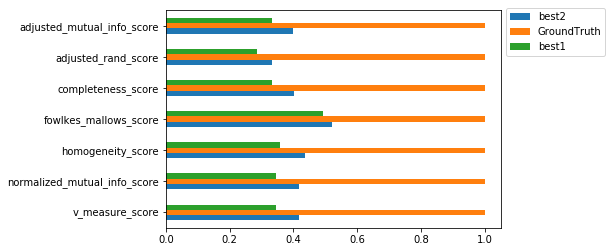

In [259]:
_ = compare_clusterings(labels_true=prodom["labels"],
                        best1=clusterings_1[2],
                        best2=clusterings_2[2],
                        GroundTruth=prodom["labels"])

<p style="background-color:#adebad;">
3. Provide a description of another reasonable transformation from similarity to dissimilarity and explain your choice.
</p>

It should be such that higher similarities go to lower dissimilarities, and they are non-negative. Plus, it's beneficial to account for the scale of data, such that multiplication of all similarities by constant and shift doesn't change $S$.

For diversity, we won't just play with parameters of the two provided families, but will try something different

For example, $D = \exp(-\frac{S - mean(S)}{std(S)})$. It satisfies this conditions (1st and 2nd obviously, 3rd - both parts of fraction scale linearly).

<p style="background-color:#adebad;">
4. Implement your transformation. <br>
5. Compare your transformation using <b>compare_clusterings()</b> with the best from task 4.0.2. You should get one plot. <br>
</p>

best2_avg = 0.41830572016425743
GroundTruth_avg = 1.0
own_avg = 0.37191240784117285
best1_avg = 0.355600310748744


,best2,GroundTruth,own,best1
v_measure_score,0.418308,1.0,0.366699,0.344688
normalized_mutual_info_score,0.418715,1.0,0.367008,0.344902
homogeneity_score,0.437612,1.0,0.382393,0.357273
fowlkes_mallows_score,0.521709,1.0,0.493469,0.492415
completeness_score,0.400635,1.0,0.352243,0.332959
adjusted_rand_score,0.331283,1.0,0.290155,0.284862
adjusted_mutual_info_score,0.399878,1.0,0.351419,0.332102


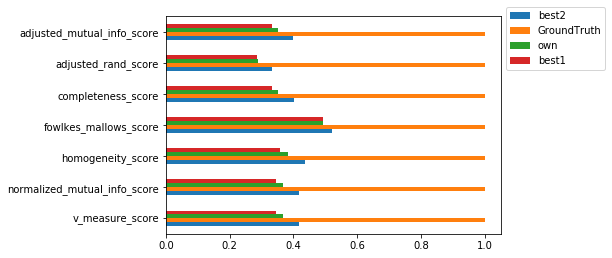

In [256]:
#Please add your code here
S = prodom["similarity"]
ma = np.max(prodom["similarity"])
mi = np.min(prodom["similarity"])
mam = np.matlib.repmat(ma, *np.shape(S))
mim = np.matlib.repmat(mi, *np.shape(S))
ones = np.ones(np.shape(S)[0])
D_own = np.exp(-(S - np.mean(S)) / np.std(S))  # decreasing function, values to > 0
PC = PairwiseClustering()
clusterings_own = PC.fit_predict(D_own)
_ = compare_clusterings(labels_true=prodom["labels"],
                        best1=clusterings_1[2],
                        best2=clusterings_2[2],
                        own=clusterings_own,
                        GroundTruth=prodom["labels"])

Our transformation is worse than the best from the second family, but better than the best from the first, which is not so bad

<h2 style="background-color:#f0b375;">
Section 5.5 
<span style=font-size:50%> Complete all problems in this (5.5.1-5.5.6) and previous sections to get a grade of 5.5 </span>
</h2>

In this section, you have to  implement and calculate cost function and investigate the stability of pairwise clustering in terms of obtained values of the clustering cost function, providing experiments for different random seeds and number of clusters.

<p style="background-color:#adebad;">
1. Implement the cost function of the <b>PairwiseClustering class</b>. <br>
2. Compute the cost function for <b>Protein</b> data. <br>
3. Calculate the execution time. <br>
</p>

With adjusted cost there is to the negative, and therefore costs become negative

It is possible, when, e.g., almost all points are in one cluster with one point per cluster for other clusters (we can imagine such a graph, with huge tightly connected component and far-away radially uniformly distributed other $K-1$ points).

Then multiplication of two $M$-elements isn't $0$ only for this large cluster $\nu_0$, but ist $p_{\nu_0}$ is then almost 1 (if points $\gg$ clusters, as we have), and therefore $M_{k\nu_0}M_{l\nu_0}/p_{\nu_0} - 1$ is near zero, whereas for all other one-point clusters $\nu\ne\nu_0$ it's $-1$. As dissimilarities between one-cluster points are big too (whereas betwee points in huge cluster they are relatively small), they will lead to negative overall cost.

In order to have similar values as in [1], we removed adjustment (just subtraction of ones matrix) (probably in [1] not unadjusted was used)

In [260]:
%%time
PC = PairwiseClustering()
PC.fit_predict(protein["dissimilarity"])
print(PC.cost(protein["dissimilarity"], PC.M, adjusted=True))
print(PC.cost(protein["dissimilarity"], PC.M, adjusted=False))

-294.7357302621054
807.4043166862515
CPU times: user 167 ms, sys: 3.9 ms, total: 171 ms
Wall time: 126 ms


<p style="background-color:#adebad;">
4. Re-run <b>fit_predict()</b> with 10 different random seeds and plot the distribution of clustering costs as shown in Figure 1 of reference [1]. <br>
5. Visualize the histograms of obtained cost functions.You should get 2 histograms; one for <b>Prodom</b> and the other for <b>Protein</b> data. Hint: use <b>matplotlib.plot.hist()</b> to plot histograms of cost functions.
</p>

<p style="background-color:#adebad;">
<b>NOTE:</b> For ProDom data use the best transformation from section 5.0 to transform similiarities to dissimiliraties. 
</p>

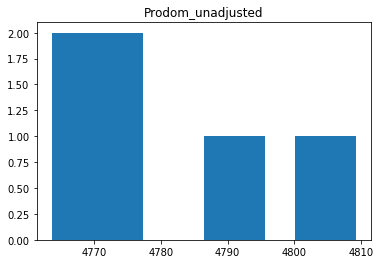

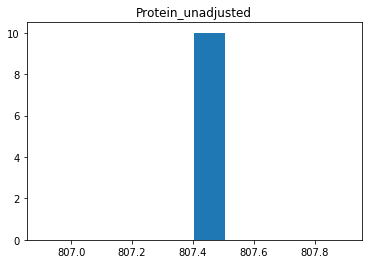

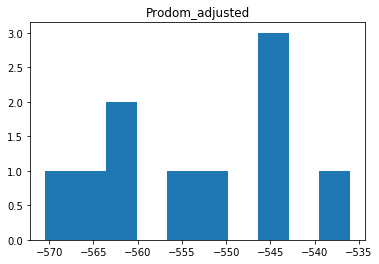

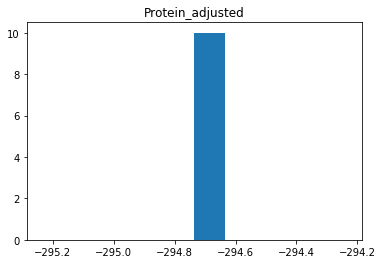

CPU times: user 4min 31s, sys: 1.77 s, total: 4min 32s
Wall time: 2min 25s


In [127]:
%%time
# Please use Problem 5.0 to transform similarities for ProDom data
# data = [protein,prodom]
# other parameters are default

# Please add your code here
S = prodom["similarity"]
mim = np.matlib.repmat(mi, *np.shape(S))
ones = np.ones(np.shape(S)[0])
S1 = ma / (ones + S - mim)
prodom_transformed = np.log(S1)

for adj, true_false in {"adjusted": True, "unadjusted": False}.items():
    for key, data in {"Protein": protein["dissimilarity"],
                      "Prodom": prodom_transformed,
                       }.items():
        costs = []
        for i in range(10):
            random_state = np.random.randint(1000)
            PC = PairwiseClustering(random_state=random_state)
            PC.fit_predict(data)
            costs.append(PC.cost(data, PC.M, adjusted=true_false))                       

        plt.hist(costs)
        plt.title(key + "_" + adj)
        plt.show()

<p style="background-color:#adebad;">
6. Perform the experiment for all the settings listed below, and visualize the results properly. You should get 4 histograms; one for each different number of clusters. <br>
</p>

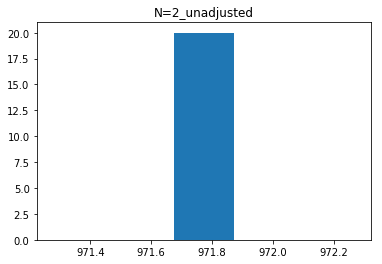

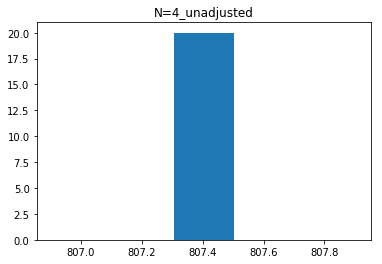

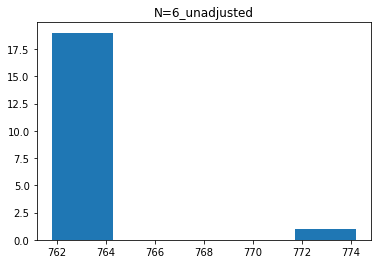

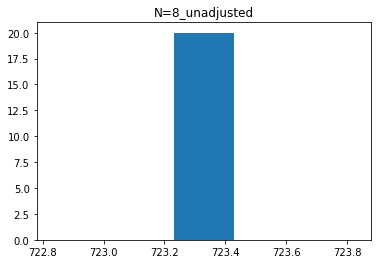

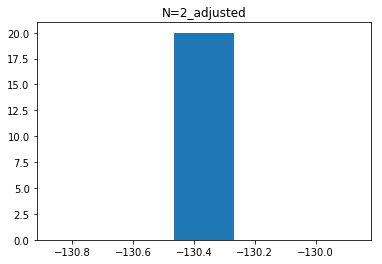

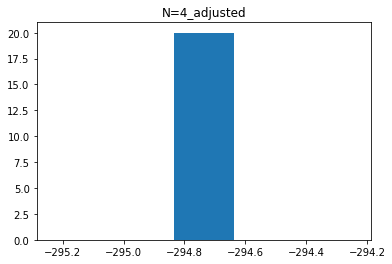

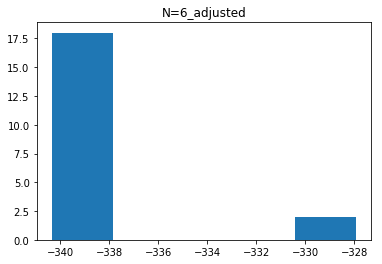

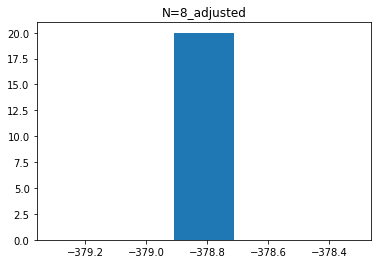

CPU times: user 1min 5s, sys: 919 ms, total: 1min 6s
Wall time: 34.4 s


In [128]:
%%time
# n_clusters = [2, 4, 6, 8]
# data = protein
# other parameters are default

#Please add your code here
data = protein["dissimilarity"]
for adj, true_false in {"adjusted": True, "unadjusted": False}.items():
    for n_clusters in [2, 4, 6, 8]:
        costs = []
        for i in range(20):
            random_state = np.random.randint(1000)
            PC = PairwiseClustering(n_clusters=n_clusters,
                                    random_state = random_state)
            PC.fit_predict(data)
            costs.append(PC.cost(data, PC.M, adjusted=true_false))                                   
        plt.hist(costs, bins=5)
        plt.title("N={}".format(n_clusters) + "_" + adj)
        plt.show()

costs are mainly identical, therefore histograms aren't very informative

<h2 style="background-color:#f0b375;">
Section 6.0
<span style=font-size:50%> Complete all problems (6.0.1-6.0.5) in this and previous sections to get a grade of 6.0 </span>
</h2>



In this section, you must implement an EM-like procedure to obtain data embeddings in the Euclidean space, while visualizing these clusters on a 2d plane.

<p style="background-color:#adebad;">
1. Provide a description of the EM-like procedure for pairwise clustering in case we want to get embeddings (algorithm III in reference [1]). <br>
</p>

$$\mathbf{K}_{i} \mathbf{x}_{i} \approx \frac{1}{2} \sum_{\nu=1}^{K}\left\langle M_{i \nu}\right\rangle\left(\left\|\mathbf{y}_{\nu}\right\|^{2}-\mathcal{E}_{i \nu}^{*}\right)\left(\mathbf{y}_{\nu}-\sum_{\mu=1}^{K}\left\langle M_{i \mu}\right\rangle \mathbf{y}_{\mu}\right), \;\;\; (5)$$
where
$$\mathbf{K}_i = \langle \mathbf{y} \mathbf{y}^\top\rangle_i - \langle\mathbf{y} \rangle_i\langle\mathbf{y}\rangle_i^\top$$
and $$\langle\mathbf{y} \rangle_i = \sum_{\nu=1}^K \langle M_{i\nu}\rangle \mathbf{y}_\nu$$

Centroid condition
$$\mathbf{y}_{\nu}=\sum_{k=1}^{N} M_{k \nu} \mathbf{x}_{k} / \sum_{k=1}^{N} M_{k \nu}\;\;(6)$$ 

$$\langle M_{i\nu}\rangle = \frac{\exp(-||\mathbf{x}_i - \mathbf{y}_\nu||^2/T)}{\sum_{\nu = 1}^K \exp(-||\mathbf{x}_i - \mathbf{y}_\nu||^2/T)}\;\;\; (7)$$ 

**EM-algorithm**

Given are matrix of pairwise dissimilarities of $N$ points $\mathcal{D}$ of size $N\times N$, initial temperature $T_0>0$, needed $K$ and low dimension $d$.

0) Initialize ${\mathbf{\hat{x}}_i}^{(0)}\in\mathbb{R}^d$,  $\langle M_{i\nu}\rangle^{(0)}\in \{0,1\}$ randomly, current temperature $T\leftarrow T_0$, minimal temperature $T_{\text{final}}$.

WHILE $T>T_{\text{final}}$ DO:

$\hspace{1cm}$
$t\leftarrow0$

$\hspace{1cm}$
REPEAT
    
$\hspace{2cm}$
E-step: estimate all $\langle M_{i\nu}\rangle^{(t+1)}$ from (7) using $\{{\mathbf{\hat{x}}_i}^{(t)}, {\mathbf{\hat{y}}_\nu}^{(t)}\}$

$\hspace{2cm}$
M-step: 

$\hspace{2cm}$
REPEAT

$\hspace{3cm}$
calculate all ${\mathbf{\hat{x}}_i}^{(t+1)}$ from corresponding (5) using $\langle M_{i\nu}\rangle^{(t+1)}$, ${\mathbf{\hat{y}}_\nu}^{(t+1)}$ and estimated before $\mathcal{E}_{i\nu}^*$.

$\hspace{3cm}$
Update ${\mathbf{\hat{y}}_\nu}^{(t+1)}$ from centroid condition (6)

$\hspace{2cm}$
UNTIL convergence

$\hspace{2cm}$
$t\leftarrow t+1$
    
$\hspace{1cm}$
UNTIL convergence

$\hspace{1cm}$
Change $T$ according to schedule (e.g. $T\leftarrow T/2$)

$\hspace{1cm}$
$\langle M_{i\nu}\rangle^{(0)} \leftarrow \langle M_{i\nu}\rangle^{(t)},
{\mathbf{\hat{x}}}^{(0)} \leftarrow {\mathbf{\hat{x}}}^{(t)}$,
${\mathbf{\hat{y}}_\nu}^{(0)} \leftarrow {\mathbf{\hat{y}}_\nu}^{(t)}$.

<p style="background-color:#adebad;">
2.  Implement Algorithm III in [1], which explains how to compute an embedding within the EM-like procedure. In code <b>fit_predict()</b>: the <b>embed == True</b> part.<br>
3. Predict a clustering for the <b>Protein</b> data.<br>
4. Calculate the execution time.<br>
</p>

Doesn't converge, don't know why (and with fixed number of iterations in WHILE loops, blows up, as can be seen below)

In [77]:
%%time
np.random.seed(111)
PCE = PairwiseClustering(embed=True)
#Please add your code here
PCE.fit_predict(protein["dissimilarity"], embed=True)

x_emb[0] [1.65798864 1.20859913], t_emb= 0
x_emb[0] [-1.40131366 -6.80042213], t_emb= 500
x_emb[0] [-3.04727569  2.53398374], t_emb= 1000
x_emb[0] [-3.46164009 10.84424832], t_emb= 1500
x_emb[0] [-2.47693648 14.77166615], t_emb= 2000
x_emb[0] [-0.49114443 12.72890913], t_emb= 2500
x_emb[0] [1.69315201 5.54158781], t_emb= 3000
x_emb[0] [ 3.19313499 -3.88542783], t_emb= 3500
x_emb[0] [  3.40257251 -11.7421101 ], t_emb= 4000
x_emb[0] [  2.23681313 -14.853058  ], t_emb= 4500
x_emb[0] [  0.16701163 -11.96092611], t_emb= 5000
x_emb[0] [-1.97028538 -4.23463644], t_emb= 5500
x_emb[0] [-3.31126843  5.20315116], t_emb= 6000
x_emb[0] [-3.31395638 12.53800974], t_emb= 6500
x_emb[0] [-1.97726422 14.80546335], t_emb= 7000
x_emb[0] [ 0.15856862 11.0890822 ], t_emb= 7500
x_emb[0] [2.23031334 2.89088944], t_emb= 8000
x_emb[0] [ 3.40064437 -6.4756983 ], t_emb= 8500
x_emb[0] [  3.19655673 -13.22503596], t_emb= 9000
x_emb[0] [  1.70053813 -14.62929488], t_emb= 9500
x_emb[0] [ -0.48277588 -10.12092624], t_

<p style="background-color:#adebad;">
5. Cluster the Protein data and properly visualize the embedding for <b>n_components=2</b>. Hint: <b>use matplotlib.pyplot.scatter()</b> to plot clusters on 2d plane using different colors for different clusters.
</p>

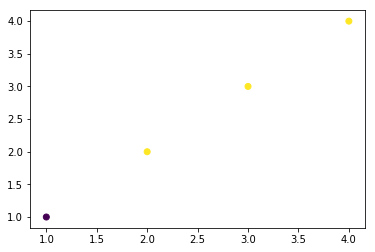

In [78]:
#Please add your code here
plt.scatter(PCE.x_emb[:,0], PCE.x_emb[:,1], c=PCE.labels)

## Comments

We hope you found this exercise instructive.

Feel free to leave comments below, we will read them carefully.